# Comparison with Satellite Laser Ranging (SLR) TWSA

In this notebook, we compare our TWS reconstruction to a TWS product from IGG Bonn which combines gravity field measurements of SLR and DORIS.

In [1]:
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [4]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

ours_list = []

for inp_name in ["era", "era-rdcd", "wghm-era"]:
    twsa_ours = xr.open_zarr(pred_dir / f"ensemble-mixed_{inp_name}_best-mae.zarr").twsa
    ours_list.append(twsa_ours.rename(f"twsa_ours_{inp_name}"))
ours = xr.merge(ours_list)


In [5]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"
slr_store = ROOT_DIR / "data/processed/igg-slr-hybrid.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
slr = xr.open_zarr(slr_store)
recs = xr.open_zarr(recs_store)


In [6]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, slr, recs, ours])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


Specify variables of interest and their descriptive names:

In [7]:
vars_verbose = {
    "twsa_ours_era-rdcd": "DeepRec, 4×ERA5",
    "twsa_ours_era": "DeepRec, 14×ERA5",
    "twsa_ours_wghm-era": "DeepRec, WGHM+14×ERA5",
    "twsa_gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "twsa_csr": "CSR (GRACE)",
}
eval_names = vars_verbose.keys()


In [8]:
grace_name = "twsa_csr"
slr_name = "twsa_slr_gauss"


Remove time steps not available in the evaluation product:

In [9]:
ds_slrtime = ds_all[[*eval_names, slr_name]].where(slr.time, drop=True).compute()

[########################################] | 100% Completed | 7.99 s


Calculate basin averages:

In [10]:
# Dims: ("model", "region")
ds_basin = (
    # Basins over 200,000 km²
    ds_slrtime.chunk(lat=-1, lon=-1, time=10)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
).compute()
ds_basin


[########################################] | 100% Completed | 96.59 s


<xarray.Dataset> Size: 2MB
Dimensions:                (time: 332, region: 72)
Coordinates:
  * time                   (time) datetime64[ns] 3kB 1992-11-01 ... 2020-06-01
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
Data variables:
    twsa_ours_era-rdcd     (region, time) float64 191kB -151.7 -89.41 ... -49.32
    twsa_ours_era          (region, time) float64 191kB -138.5 -68.82 ... -53.09
    twsa_ours_wghm-era     (region, time) float64 191kB -139.7 -68.03 ... -54.59
    twsa_gap               (region, time) float64 191kB -138.3 -64.19 ... -54.38
    humphrey_gsfc_detrend  (region, time) float64 191kB -217.4 -128.4 ... nan
    li_csr_full            (region, time) float64 191kB -201.1 -128.5 ... -62.84
    yin_csr_full           (region, time) float64 191kB -133.0 -75.3 ... -43.17
    twsa_csr               (region, time) float64 191kB nan nan ... -56.81
    twsa_slr_gauss         (region, time) float64 191kB -192.3 -82.75 ... -31.0

Split into Pre-GRACE and GRACE periods:

In [11]:
ds_basin_pre = ds_basin.drop_vars(grace_name).sel(time=slice(None, "2001"))
ds_basin_post = ds_basin.sel(time=slice("2002", None))
# Drop time stamps which are not available for at least one variable
ds_basin_pre = ds_basin_pre.where(ds_basin_pre.dr.time_notnull("region"), drop=True)
ds_basin_post = ds_basin_post.where(ds_basin_post.dr.time_notnull("region"), drop=True)

### Basin scale PCC

In [12]:
# Calculate PCC for pre-GRACE era
da_pcc_pre = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_pre.drop_vars(slr_name),
    ds_basin_pre[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")

# Calculate PCC for GRACE era
da_pcc_post = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_post.drop_vars(slr_name),
    ds_basin_post[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")


In [13]:
# Combine along new `era` dimension
pcc_basin = xr.concat(
    [da_pcc_pre, da_pcc_post], dim=pd.Index(["pre", "post"], name="era")
)


## Map plots

In [14]:
plot_kwargs = dict(
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    cmap=cmc.lipari_r,
    vmin=0,
    vmax=1,
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.02, label="PCC"),
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True),
    figsize=(6, 8.25),
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.5, facecolor="None", rasterized=True, zorder=3.0
)


In [15]:
# Create a dummy array with the dimensions (model x lat x lon)
da_dummy_post = ds_slrtime[eval_names].isel(time=0, drop=True).to_dataarray("model")
da_dummy_pre = da_dummy_post.drop_sel(model=grace_name)

In [16]:
# Get start and end years of time series
times_pre = ds_basin_pre.get_index("time")
times_post = ds_basin_post.get_index("time")

period_pre = (times_pre[0].year, times_pre[-1].year)
period_post = (times_post[0].year, times_post[-1].year)

c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


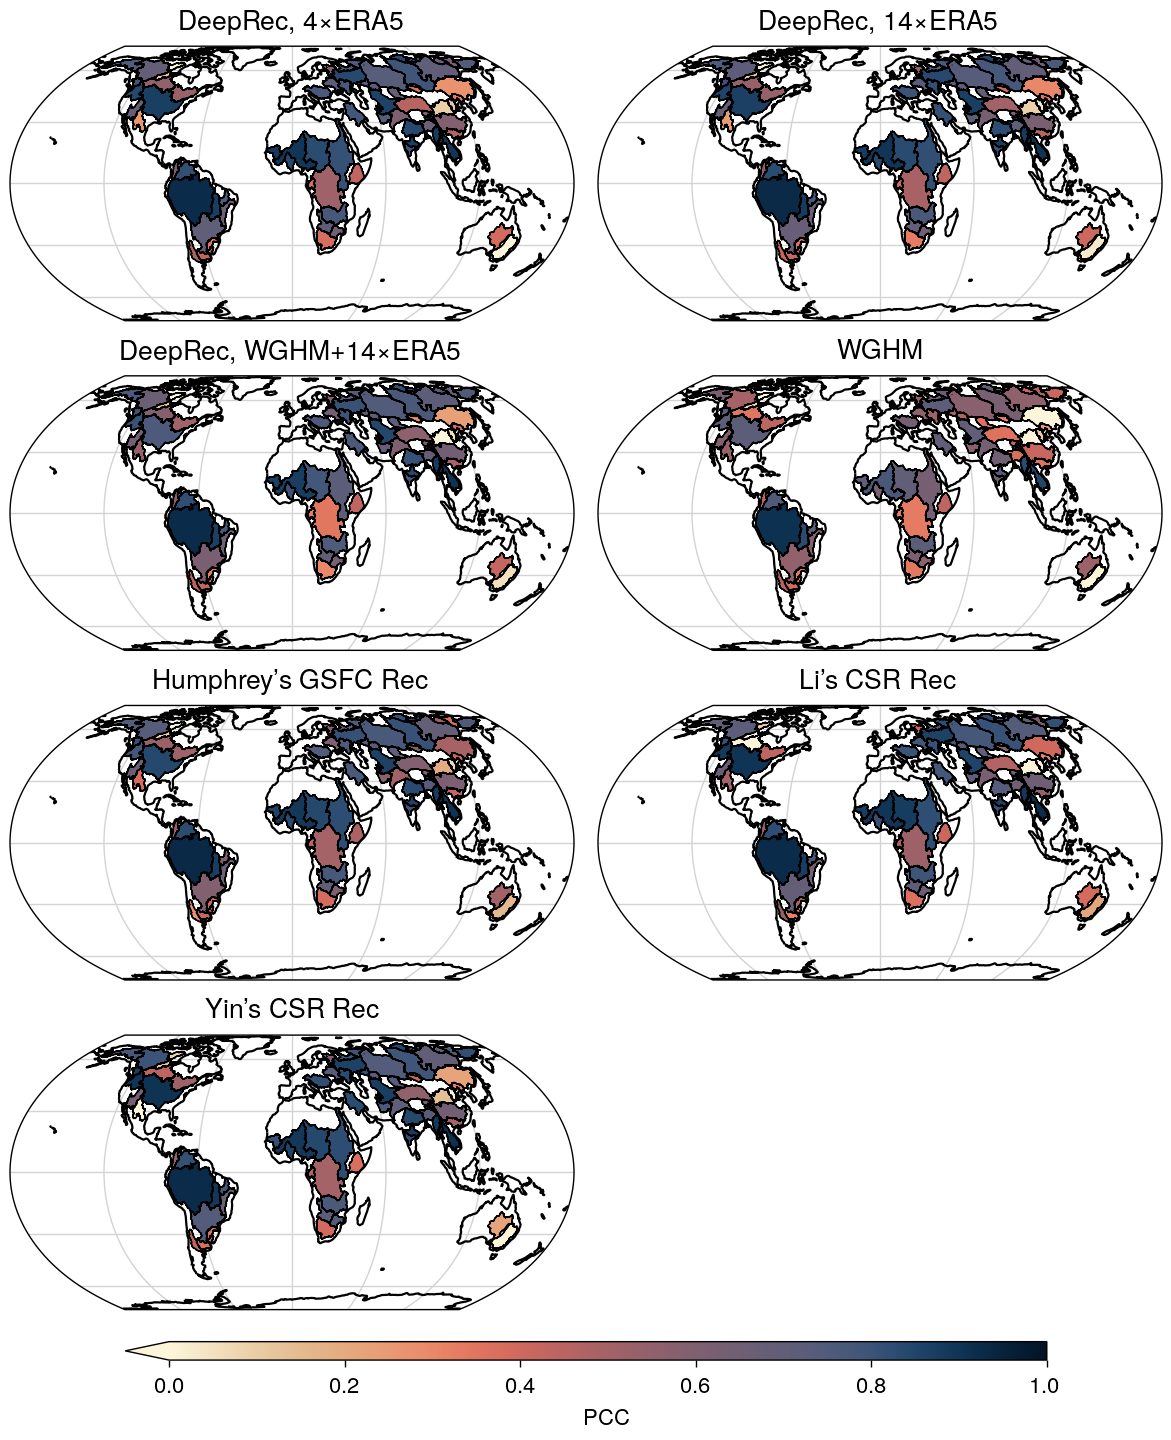

In [17]:
p = da_pcc_pre.dr.projplot_basins(
    da_dummy_pre,
    col="model",
    **plot_kwargs,
)

# Plot basin shapes
basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_pcc_pre.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(
    FIGURE_DIR / f"slr_pcc_{period_pre[0]}-{period_pre[1]}.pdf", backend="pgf"
)


c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


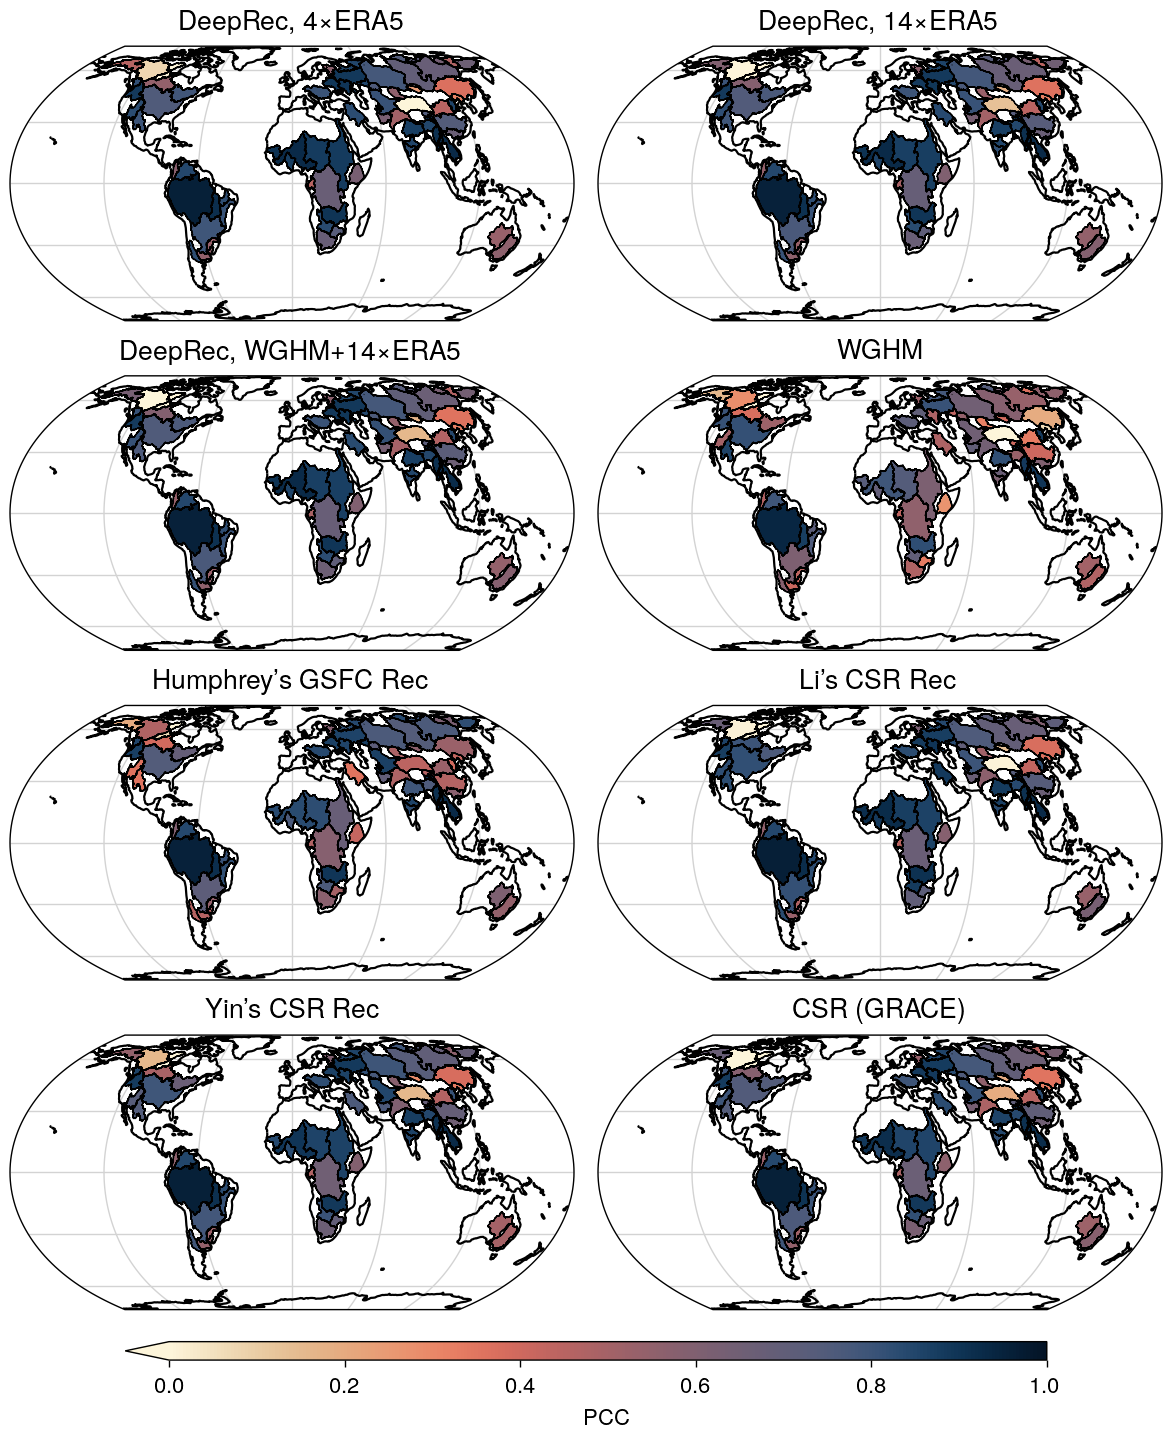

In [18]:
p = da_pcc_post.dr.projplot_basins(
    da_dummy_post,
    col="model",
    **plot_kwargs,
)

# Plot basin shapes
basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_pcc_post.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(
    FIGURE_DIR / f"slr_pcc_{period_post[0]}-{period_post[1]}.pdf", backend="pgf"
)
